In [ ]:
#@title Data Loading (Run me!)
import pandas as pd
users = pd.read_csv("https://www.dropbox.com/s/fgx51qachbbuw8f/users_.csv?dl=1")
purchases = pd.read_csv('https://www.dropbox.com/s/12ts23fgo214975/purchases_.csv?dl=1')

В переменные users и purchases (pands.DataFrame) загружены данные о пользователях, попавших в а/б тест и их покупках.

А/б тест направлен на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

```
Описание данных:

В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
tag - лэйбл группы (control - контрольная, остальные - тестовые)
ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
user_uid - внутренний id юзера (для матчинга со второй таблицей)
registration_time - время регистрации пользователя в сервисе
conv_ts - время совершения первой покупки пользователем в сервисе

В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
user_uid - внутренний id юзера (для матчинга со второй таблицей)
time - время совершения транзакции
consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
element_uid - уникальный id единицы контента или подписки
price - цена (преобразованная)

Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.
```



# Идеи по метрикам:

Я выбрал метрики: AOV - средний чек, доля покупок той или иной услуги

AOV - хорошо показывает насколько увеличилась платежная активность

Доли услуг - также могут показать активность. Я делал выводы по этой метрике с рассчетом, что подписка или аренда ценнее dto.

Можно было бы также посмотреть на Churn и Retention, если взять какой-нибудь период времени, однако почти все первые покупки и регистрации были начаты до запуска тестов. Поэтому мне показалось их не очень эффективно использовать.

**Для вывода графиков я использовал plotly - если просматривать графики заранее на некоторых платформах, они могут некорректно отображаться.**

In [ ]:
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu


Перед тем как матчить посмотрим отдельно на таблицы

Заметим, что в таблице users - есть повторяющиеся user_uid

In [ ]:
print("Всего", users.user_uid.shape)
print("Уникальных", users.user_uid.unique().shape)

Всего (696982,)
Уникальных (694819,)


Посмотрим на количество нанов в таблице

In [ ]:
users.isna().sum()

tag                    0
ts                     0
user_uid               0
registration_time    497
conv_ts              285
dtype: int64

In [ ]:
purchases.isna().sum()

user_uid            0
time                0
consumption_mode    0
element_uid         0
price               0
dtype: int64

Посмотрим на размер выборок - все равны в целом в количестве

In [ ]:
users.tag.value_counts()

test1      140133
test2      139389
test4      139254
test3      139226
control    138980
Name: tag, dtype: int64

Мысли насчёт воронки: все пользователи уже зарегестрированы, поэтому мы смотрим только на транзакции пользователей и их анализируем

# Разделим данные до распределения тэгов и после

In [ ]:
print(users.shape)
print(purchases.shape)

(696982, 5)
(663849, 5)


Я выбрал тип слияния inner так как нам важны и пользователи и их действия. Но как показала практика - right даёт тоже самое число строк из чего можно сделать вывод, что аользователи из purchases полностью лежат в users. 

Но из-за того что в user_uid не все строки уникальны, поэтому могут быть выбросы или недосчет каких-либо транзакций. Однако, количестов уникальных почти равно общему и размер выборки достаточно большой, чтобы эту проблему считать неущественной

In [ ]:
merged = pd.merge(users, purchases, on=["user_uid"], how="inner")
merged

tag            ts                          user_uid  \
0       control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1   
1       control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1   
2       control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1   
3       control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1   
4       control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1   
...         ...           ...                               ...   
667554    test4  30135.493437  23f24586aaddd9229c724fac4725c94f   
667555    test4  30135.493437  23f24586aaddd9229c724fac4725c94f   
667556    test4  30135.493437  23f24586aaddd9229c724fac4725c94f   
667557    test4  30135.493437  23f24586aaddd9229c724fac4725c94f   
667558    test4  30135.493437  23f24586aaddd9229c724fac4725c94f   

        registration_time       conv_ts          time consumption_mode  \
0            27410.171795  27632.424734  30147.939441             rent   
1            27410.171795  27632.424734  30133.782798     subscription   
2            27410.171795  27632.424734  30125.717420              dto   
3            27410.171795  27632.424734  30122.544398              dto   
4            27410.171795  27632.424734  30118.725912             rent   
...                   ...           ...           ...              ...   
667554       27410.140327  29017.771448  30158.432323             rent   
667555       27410.140327  29017.771448  30140.484255              dto   
667556       27410.140327  29017.771448  30138.977930             rent   
667557       27410.140327  29017.771448  30115.869255             rent   
667558       27410.140327  29017.771448  30112.671916     subscription   

                             element_uid      price  
0       f1ed5620d661f7d604e31509f3542504  25.647059  
1       dd7f3f7b10fb9b502cbc5d1a9abc067b  50.352941  
2       a693322f7dbc21d5064c06021b878597  35.647059  
3       80fd3378dfc91b30d85cc0bd05a37993  35.647059  
4       80fd3378dfc91b30d85cc0bd05a37993  25.647059  
...                                  ...        ...  
667554  059253ab01a83ccc0d90aa4147ecb11f  26.823529  
667555  783002315b28940b5f249dcacc3a9d00  26.823529  
667556  b7464f0fdf9b8c47e3cceeba6940da8c  26.823529  
667557  f623271b7ba61393790e9ab8cec839d4  25.647059  
667558  dd7f3f7b10fb9b502cbc5d1a9abc067b  21.058824  

[667559 rows x 9 columns]

Находим пользователей которые сделали транзакции до присуждения тэга

In [ ]:
before_tgd_transactions=merged[merged.ts>=merged.time]
before_tgd_transactions.head(3)

tag            ts                          user_uid  registration_time  \
2  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
3  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
4  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   

        conv_ts          time consumption_mode  \
2  27632.424734  30125.717420              dto   
3  27632.424734  30122.544398              dto   
4  27632.424734  30118.725912             rent   

                        element_uid      price  
2  a693322f7dbc21d5064c06021b878597  35.647059  
3  80fd3378dfc91b30d85cc0bd05a37993  35.647059  
4  80fd3378dfc91b30d85cc0bd05a37993  25.647059

Находим пользователей которые сделали транзакции после присуждения тэга

In [ ]:
tagged_transactions=merged[merged.ts<merged.time]
tagged_transactions.head(3)

tag            ts                          user_uid  registration_time  \
0  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
1  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
6  control  30136.790772  9932d33f40ad07d7f3ddb7c6aee1bc60       27410.227367   

        conv_ts          time consumption_mode  \
0  27632.424734  30147.939441             rent   
1  27632.424734  30133.782798     subscription   
6  27573.751226  30138.171910     subscription   

                        element_uid      price  
0  f1ed5620d661f7d604e31509f3542504  25.647059  
1  dd7f3f7b10fb9b502cbc5d1a9abc067b  50.352941  
6  6044f6995c3da1720dd814bafe3b2349  38.588235

# Метрика 1: Средний чек пользователей, до теста

In [ ]:
before_tgd_transactions.groupby(['user_uid']).mean().price

user_uid
0000602749161524aedd04269957e5fc    21.058824
0000f7de0da68807dee816cf21cba94a    56.235294
0001220419a9db73d7ec59ddda2a48d7    30.605042
00013810b07623f09f93c710acdd62ad    50.352941
00016a14fe3fd271286153b28e58f6bc    29.764706
                                      ...    
fffe22c729f230fe7fe21ef7b6a1b499    38.588235
fffe926a7c444e6f97e4bf6c1f5a0f90    21.058824
ffff28cc17523cac89600e472121ff83    29.764706
ffff6ca4ec2ce17ff3fc9b1b1f5134db    32.705882
ffffc093e6ad8a606ade54eea7f821b1    29.764706
Name: price, Length: 231013, dtype: float64

Среднее значение всех чеков

In [ ]:
before_tgd_transactions.groupby(['user_uid']).mean().price.mean()

35.48148179113742

# Метрика 1: Средний чек пользователей, во время теста

In [ ]:
# Средний чек по пользователям в каждой из выборок

rec_crl=(tagged_transactions[tagged_transactions.tag=="control"]).groupby(['user_uid']).mean().price
rec_t1=(tagged_transactions[tagged_transactions.tag=="test1"]).groupby(['user_uid']).mean().price
rec_t2=(tagged_transactions[tagged_transactions.tag=="test2"]).groupby(['user_uid']).mean().price
rec_t3=(tagged_transactions[tagged_transactions.tag=="test3"]).groupby(['user_uid']).mean().price
rec_t4=(tagged_transactions[tagged_transactions.tag=="test4"]).groupby(['user_uid']).mean().price

In [ ]:
rec_crl

user_uid
000373642d44d46b10c688f1d9935ae7    68.000000
0003b33473fe4329ef718b18a3bdc2ca    44.470588
00042cc33f68409d71af41e1bd24b5b6    35.647059
0007c1466c3974cc5fe1a4601bf91a53    33.686275
0009aaa578bec306ec94019d357eb3f3    38.588235
                                      ...    
fff67a336e18e8e615445990c6f994e6    21.058824
fff70f3ae2edde70647813945a188cda    44.470588
fff8b1a5d228190008da871975cc6bf0    21.058824
fffa1d3f4a5b84c34bf0884a0d19b550    38.588235
fffefaa78a322c5b4c51a7f99ed48c09    56.235294
Name: price, Length: 30117, dtype: float64

In [ ]:
rec_crl.count()+rec_t1.count()+rec_t2.count()+rec_t3.count()+rec_t4.count() # Проверка что правильно распределили

155104

Для начала давайте сравним среднее для каждого массива

In [ ]:
rec=np.array([rec_crl,rec_t1,rec_t2,rec_t3,rec_t4])


for i in rec:
  print(i.mean())

39.425775646251374
39.15921261579389
39.23957726448145
39.21798637054938
39.038160093814724


<ipython-input-18-2c0679e8d780>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Как видим, среднее для каждой выборки одинаковое, смотря на разброс цен. Это может наводить на статистическую незначимость тестов по этой метрике

Постороим boxplot по сравнению с контрольной выборкой

In [ ]:
tagged_transactions.head(2)

tag            ts                          user_uid  registration_time  \
0  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
1  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   

        conv_ts          time consumption_mode  \
0  27632.424734  30147.939441             rent   
1  27632.424734  30133.782798     subscription   

                        element_uid      price  
0  f1ed5620d661f7d604e31509f3542504  25.647059  
1  dd7f3f7b10fb9b502cbc5d1a9abc067b  50.352941

In [ ]:
#Больше 120 также присутствуют значения я их отбрсил, чтобы увидеть лучше основной масив данных

fig = go.Figure(px.box(tagged_transactions, x="tag", y="price",color="tag", title="Средний чек пользователей для каждой тестовой выборки"), layout_yaxis_range=[0,120])
fig.show()

## T-критерий стьюдента на статистическую значимость выборок

Проверим что выборки распределены по нормальному закону(критерий колмогорова)

In [ ]:
from scipy.stats import kstest


for i in rec:
  print(kstest(i, 'norm'))



KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


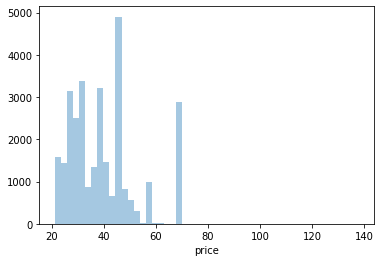

In [ ]:
# Распределение величин для контрольной группы
sns.distplot(rec_crl, kde=False) 

Из теста Колмогорова можем сделать вывод, что ни одна выборка нормально не распределена. Поэтому лучше воспользоваться критерий Манна-Уитни

## Критерий Манна-Уитни

In [ ]:
print(mannwhitneyu(rec_crl,rec_t1))
print(mannwhitneyu(rec_crl,rec_t2))
print(mannwhitneyu(rec_crl,rec_t3))
print(mannwhitneyu(rec_crl,rec_t4))



MannwhitneyuResult(statistic=481905928.5, pvalue=0.0011321338170179095)
MannwhitneyuResult(statistic=473078715.0, pvalue=0.031134962983741014)
MannwhitneyuResult(statistic=474625434.5, pvalue=0.013872868523007594)
MannwhitneyuResult(statistic=478980524.0, pvalue=2.3998248478905955e-05)


При уровне значимости 0.05 можно сделать вывод, что различия с контрольной выборкой для всех тестовых выборок статистически значимы

При уровне значимости 0.01 можно сделать вывод, что проходят проверку первая и четвертая тестовая выборка, а именно для этих выборок различия статистически значимы.

Однако, если посмотреть на средние значения чеков для контрольной и тестовых выборок, можно заметить, что для всех тестовых выборок среднее значение уменьшилось по сравнению с контрольной.

Из чего можно сделать вывод, что тестовые выборки дают отрицательный вклад в платежную активность пользователя.

Однако все выборки, включая тестовую, показали прирост среднего значения на 4 еденицы, что достаточно весомо в контексте задачи.

# Метрика 2: Доля покупки того или иного продукта до теста

In [ ]:
bef_ttl = before_tgd_transactions.consumption_mode.count()# Всего транзакций
bef_dto=before_tgd_transactions[before_tgd_transactions.consumption_mode == "dto"].count()[0] # количество dto
bef_rnt=before_tgd_transactions[before_tgd_transactions.consumption_mode == "rent"].count()[0] # количество арнед
bef_sbs=before_tgd_transactions[before_tgd_transactions.consumption_mode == "subscription"].count()[0]# количество купленных подписок

In [ ]:
bef_dto+bef_rnt+bef_sbs==bef_ttl# Проверим что правильно посчтано

True

##График

In [ ]:
title="Распределение отдельных видов транзакций Всего {bef_ttl:d}"
fig_bef=px.pie(values=[bef_dto,bef_rnt,bef_sbs],names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(bef_ttl=bef_ttl))
fig_bef.show()

# Метрика 2: Доля покупки того или иного продукта во время теста

In [ ]:
numb_tagged_transactions=tagged_transactions.tag.value_counts().sort_index()
numb_tagged_transactions#Количство транзакций в каждой выборке

control    53292
test1      56941
test2      56205
test3      56578
test4      56534
Name: tag, dtype: int64

In [ ]:
numb_tagged_transactions.index#список различных выборок

Index(['control', 'test1', 'test2', 'test3', 'test4'], dtype='object')

In [ ]:
cons_var=tagged_transactions.consumption_mode.unique()# Список различных видов покупок
cons_var.sort()
cons_var

array(['dto', 'rent', 'subscription'], dtype=object)

In [ ]:
tagged_transactions.head(3)

tag            ts                          user_uid  registration_time  \
0  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
1  control  30133.146255  deb7d0e9bf9813d4f21b579d3703c6e1       27410.171795   
6  control  30136.790772  9932d33f40ad07d7f3ddb7c6aee1bc60       27410.227367   

        conv_ts          time consumption_mode  \
0  27632.424734  30147.939441             rent   
1  27632.424734  30133.782798     subscription   
6  27573.751226  30138.171910     subscription   

                        element_uid      price  
0  f1ed5620d661f7d604e31509f3542504  25.647059  
1  dd7f3f7b10fb9b502cbc5d1a9abc067b  50.352941  
6  6044f6995c3da1720dd814bafe3b2349  38.588235

## Графики 4 тестовых выборок и контрольной

### Для Тестовой 1

In [ ]:
index=numb_tagged_transactions.index[1]

tmp=tagged_transactions[tagged_transactions.tag==index]
dist={}
for  var in cons_var:
    
  dist[var]=tmp[tmp.consumption_mode==var].count()[0]

print(dist)


title="Распределение отдельных видов транзакций для выборки {index} Всего {total:d}"
fig_test1=px.pie(values=dist.values(),names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(index=index,total=numb_tagged_transactions[index]))
fig_test1.show()

{'dto': 21100, 'rent': 18485, 'subscription': 17356}


### Для Тестовой 2

In [ ]:
index=numb_tagged_transactions.index[2]

tmp=tagged_transactions[tagged_transactions.tag==index]
dist={}
for  var in cons_var:
    
  dist[var]=tmp[tmp.consumption_mode==var].count()[0]

print(dist)


title="Распределение отдельных видов транзакций для выборки {index} Всего {total:d}"
fig_test1=px.pie(values=dist.values(),names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(index=index,total=numb_tagged_transactions[index]))
fig_test1.show()

{'dto': 20892, 'rent': 18230, 'subscription': 17083}


### Для Тестовой 3

In [ ]:
index=numb_tagged_transactions.index[3]

tmp=tagged_transactions[tagged_transactions.tag==index]
dist={}
for  var in cons_var:
    
  dist[var]=tmp[tmp.consumption_mode==var].count()[0]

print(dist)


title="Распределение отдельных видов транзакций для выборки {index} Всего {total:d}"
fig_test1=px.pie(values=dist.values(),names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(index=index,total=numb_tagged_transactions[index]))
fig_test1.show()

{'dto': 21137, 'rent': 18222, 'subscription': 17219}


### Для Тестовой 4

In [ ]:
index=numb_tagged_transactions.index[4]

tmp=tagged_transactions[tagged_transactions.tag==index]
dist={}
for  var in cons_var:
    
  dist[var]=tmp[tmp.consumption_mode==var].count()[0]

print(dist)


title="Распределение отдельных видов транзакций для выборки {index} Всего {total:d}"
fig_test1=px.pie(values=dist.values(),names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(index=index,total=numb_tagged_transactions[index]))
fig_test1.show()

{'dto': 21645, 'rent': 17940, 'subscription': 16949}


### Для контрольной

In [ ]:
index=numb_tagged_transactions.index[0]

tmp=tagged_transactions[tagged_transactions.tag==index]
dist={}
for  var in cons_var:
    
  dist[var]=tmp[tmp.consumption_mode==var].count()[0]

print(dist)


title="Распределение отдельных видов транзакций для выборки {index} Всего {total:d}"
fig_test1=px.pie(values=dist.values(),names=["Куплена навегда","Куплено в аренду","Подписка"],title=title.format(index=index,total=numb_tagged_transactions[index]))
fig_test1.show()

{'dto': 18871, 'rent': 17659, 'subscription': 16762}


## Вывод 

 Как видим во всех выборках распределение покупок различных товаров примерно совпадает и при том они примерно равнораспределены. **Но** до теста ситуация другая - был перевес в сторону подписки и dto

# Итоги

Выбранные мною метрики: AOV - показала, что тестовые выборки хуже контрольных, если считать по среднему. Зато они все лучше, той, которая была до разделения воронки. Тут, по моему мнению, можно тогда проверить как именно разделялись данные на тестирование, чтобы обьяснить такие результаты.

Аналогично для второй метрики - долей покупок. Во время теста выборки очень похожи - во всех примерно одинаковое соотношение купленных услуг, а до теста выборка дает уже перевес к подпискам dto.

In [ ]:
# fig = make_subplots(rows=2, cols=2)

# traces=np.array([])

# i=1 #Индексы для subplots
# j=1

# for index in numb_tagged_transactions.index[1:]:

#   print(index)

#   tmp=tagged_transactions[tagged_transactions.tag==index]

#   dist={} # Создаем словар для pie chart
#   for var in cons_var:
    
#     dist[var]=tmp[tmp.consumption_mode==var].count()[0]

#     print(dist)

#   # title = "Распределение отдельных видов транзакций в выборке {index} Всего {total:d}"

#   tmp=go.Pie(
#       values=[1,2,3],
#       labels=["Куплена навегда","Куплено в аренду","Подписка"]),
#       domain=dict(x=[0+i/4, i/4+0.25])))

#   traces=np.append(traces,tmp)

#   # fig.append_trace(go.Pie(values=dist.values(),
#   #                         labels=["Куплена навегда","Куплено в аренду","Подписка"],
#   #                         title=title.format(index=index, total=numb_tagged_transactions[index])))

  

 
  
#   i+=1


# # fig.append_trace(go.Scatter(
# #    x=[1,2,3,4,5],
# #    y=[5,6,7,8,9],
# # ), row=1, col=1)

# # fig.append_trace(go.Scatter(
# #    x=[3,4,5,6,7],
# #    y=[10,11,12,9,8],
# # ), row=1, col=2)

# # fig.append_trace(go.Scatter(
# #    x=[4,5,6,7,8],
# #    y=[6,7,8,9,10]
# # ), row=2, col=1)

# # fig.update_layout(height=1000, width=1000, title_text="Subplots")
# # fig.show()